# Predict Credit card Approval
Made by
- Yannick K. Hartington

The task here is to build a machine learning model to predict if an applicant is a 'good' or 'bad' client, were the definition of 'good' or 'bad' is not given. Thus, we need to find a way to construct the labels. Lastly, imbalance data problem is a big problem in this task, which also needs to be handle. 

# Table of content

- [Data Overview](#data-overview)
    - [Application record](#application-record)
    - [Credit record](#credit-record)
- [Data Preprocessing](#data-preprocessing)
- [Response variable](#response-variable)

### Import necessary libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

### Load datasets

In [4]:
try:
    dataset_path = r'/mnt/c/Datasets/Credit Card Approval' # WSL
except FileNotFoundError:
    dataset_path = r'C:\Datasets\Credit card approval' # Windows

application_record_path = os.path.join(dataset_path, 'application_record.csv')
credit_record_path = os.path.join(dataset_path, 'credit_record.csv')

In [5]:
application_record_df = pd.read_csv(application_record_path)
credit_record_df = pd.read_csv(credit_record_path)

## Data Overview
We will start out with inspecting the two datasets to achieve a better understanding of them. This will also enable us to get a better idea if and how we should transform some of the features.

But first a little information about the two datasets we have.
- application_record.csv contains appliers personal information
- credit_record.csv records users' behaviors of credit card
- They are connected by the ID column

Further information regarding the datasets and their features can be found [here](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data). However, I find it necessary to describe a few features in the datasets. 

The application_record dataset contains two of these features:
- **DAYS_BIRTH** is the number of days since the person was born. It count backward from current day (0). Thus -1 means yesterday.
- **DAYS_EMPLOYED** is how many days the person has been employed. It count backward from current day (0) and if the number is positive, it means the person is currently unemployed.

The credit_record dataset do also contains two of these:
- **MONTHS_BALANCE** is the month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on.
- **STATUS** contains one of the following categories:
    - 0: 1-29 days past due 
    - 1: 30-59 days past due 
    - 2: 60-89 days overdue 
    - 3: 90-119 days overdue 
    - 4: 120-149 days overdue 
    - 5: Overdue or bad debts, write-offs for more than 150 days 
    - C: paid off that month 
    - X: No loan for the month

Now lets inspect the two datasets and see if we have to transform any of the features.

### Application record


In [4]:
application_record_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [5]:
application_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

By looking at some rows and the summary of the dataset, it was revealed that we have a few things we need to handle:
- **ID** should be converted to strings since the IDs represent the client number, which is categorical and have no numerical value.
- The binary encoding features are not constructed the same way since some contains "Y" for yes and "N" for no and others use 1 for yes and 0 for no. We would like the latter. Thus, the features we need to transform is:
    - **FLAG_OWN_CAR**
    - **FLAG_OWN_REALTY**
- **OCCUPATION_TYPE** contains alot of missing values, which we have to look further into. 
- **DAYS_BIRTH** should be converted to something more relatable like the persons age in years.

These things will be handled in the *Data Preprocessing* section.

### Credit record

In [6]:
credit_record_df

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [7]:
credit_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


Also for this dataset should we convert the **ID** to strings.

## Initial Data Preprocessing
In this section we'll do some basic cleaning of the data by removing duplicates, correct data types, handle missing values. Furthermore, we'll do some basic feature engineering to make features values more relatable.

### Application record

#### ID

In [8]:
# Convert ID to strings
application_record_df['ID'] = application_record_df['ID'].astype(str)

Next we check if the ID column is unique 

In [9]:
application_record_df['ID'].is_unique

False

Lets have a look on the rows, where the ID occurs more than once

In [10]:
dublicates = application_record_df.duplicated(subset=['ID'], keep=False)
application_record_df[dublicates].sort_values(by='ID')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


It does not look like the rows are duplicates and we can not tell which are correct, so we are going to remove these from the dataset.

In [11]:
application_record_df = application_record_df[~dublicates]
application_record_df['ID'].is_unique # Check that the ID column is now unique 

True

In [12]:
# Make the ID as the index
application_record_df = application_record_df.set_index('ID')

#### FLAG_OWN_CAR & FLAG_OWN_REALTY

In [13]:
application_record_df['FLAG_OWN_CAR']

ID
5008804    Y
5008805    Y
5008806    Y
5008808    N
5008809    N
          ..
6840104    N
6840222    N
6841878    N
6842765    N
6842885    N
Name: FLAG_OWN_CAR, Length: 438463, dtype: object

In [14]:
application_record_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0}, inplace=True)

C:\Users\yann1\AppData\Local\Temp\ipykernel_20176\2423241095.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  application_record_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0}, inplace=True)


In [15]:
# Replace 'Y' with 1 and 'N' with 0 
application_record_df['FLAG_OWN_CAR'] = application_record_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
application_record_df['FLAG_OWN_REALTY'] = application_record_df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})

C:\Users\yann1\AppData\Local\Temp\ipykernel_20176\2867520990.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  application_record_df['FLAG_OWN_REALTY'] = application_record_df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})


#### Missing values
Lets get a better view of OCCUPATION_TYPE, which was the only feature with missing values

In [16]:
# Count of different values including NaN
application_record_df['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
NaN                      134177
Laborers                  78225
Core staff                42993
Sales staff               41092
Managers                  35477
Drivers                   26085
High skill tech staff     17283
Accountants               15980
Medicine staff            13518
Cooking staff              8074
Security staff             7993
Cleaning staff             5843
Private service staff      3455
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: count, dtype: int64

In [17]:
# Percentage of different values including NaN
application_record_df['OCCUPATION_TYPE'].value_counts(normalize=True, dropna=False) * 100

OCCUPATION_TYPE
NaN                      30.601670
Laborers                 17.840730
Core staff                9.805388
Sales staff               9.371828
Managers                  8.091219
Drivers                   5.949191
High skill tech staff     3.941724
Accountants               3.644549
Medicine staff            3.083042
Cooking staff             1.841432
Security staff            1.822959
Cleaning staff            1.332610
Private service staff     0.787980
Low-skill Laborers        0.488069
Secretaries               0.466174
Waiters/barmen staff      0.379736
Realty agents             0.237420
HR staff                  0.176526
IT staff                  0.137754
Name: proportion, dtype: float64

So, OCCUPATION_TYPE is missing about 31% of its values. One way to deal with the rows that are missing data, is simply to remove them from our dataset. However, there is no clear category for unemployed. Thus, you could argue would be the missing values. I will therefore replace the missing values with the string "Unemployed", so they are also represented in the dataset. Howerver, be aware that this could be a misinterpretation of the data.

In [18]:
# Replace missing values with 'Unemployed'
application_record_df['OCCUPATION_TYPE'] = application_record_df['OCCUPATION_TYPE'].fillna('Unemployed')
application_record_df['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
Unemployed               134177
Laborers                  78225
Core staff                42993
Sales staff               41092
Managers                  35477
Drivers                   26085
High skill tech staff     17283
Accountants               15980
Medicine staff            13518
Cooking staff              8074
Security staff             7993
Cleaning staff             5843
Private service staff      3455
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: count, dtype: int64

#### DAYS_BIRTH

In [19]:
# Make the days positive and divide by the number of days in a year
application_record_df['AGE'] = (-application_record_df['DAYS_BIRTH'] / 365).astype(int) 

In [20]:
application_record_df = application_record_df.drop(columns='DAYS_BIRTH')

### Credit record

#### ID

In [21]:
# Convert ID to strings
credit_record_df['ID'] = credit_record_df['ID'].astype(str)

## Response variable
We need to construct the labels of who is a 'good' and 'bad' client, however I do not have a lot of knowledge in this specific domain. Thus I have chosen to use a simple method, which just put every client that have been more than 60 days overdue, as a bad client.

In [22]:
risk_ids = credit_record_df[credit_record_df['STATUS'].isin(['2', '3', '4', '5'])]['ID'].drop_duplicates()

application_record_df['RISK'] = application_record_df.index.isin(risk_ids).astype(int)

## Exploratory Data Analysis (EDA)
Now, lets perform an EDA, which will be done to examine the dataset and summarize the main characteristics. This will among other things help us understand the data even better, detect patterns and spot anomalies. 

Lets start by looking at our newly created response variable

### Response variable

In [23]:
risk_count = application_record_df['RISK'].value_counts()
risk_count

RISK
0    437847
1       616
Name: count, dtype: int64

In [24]:
risky_ids_count = risk_count[1]
percentage_ones = (risky_ids_count / risk_count.sum()) * 100

print(f"The sum of risky IDs: {risky_ids_count}")
print(f"Percentage of risky IDs: {percentage_ones:.2f}%")

The sum of risky IDs: 616
Percentage of risky IDs: 0.14%


We can see that only 0.14% of all the clients is bad, which shows the big imbalance problem we have in this dataset. <br>Lets explore the dataset some more and look at the features.

### Application record

In [25]:
categorical_cols = application_record_df.select_dtypes(include=['object']).columns
numerical_cols = application_record_df.select_dtypes(include=[np.number]).columns

# Check for binary columns within numerical columns
binary_cols = [col for col in numerical_cols if 'FLAG' in col]

# Remove binary columns from numerical columns list
numerical_cols = [col for col in numerical_cols if col not in binary_cols and col != 'RISK']

print('Categorical columns:\n', categorical_cols)
print('')
print('Numerical columns:\n', numerical_cols)
print('')
print('Binary columns:\n', binary_cols)

Categorical columns:
 Index(['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'],
      dtype='object')

Numerical columns:
 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'AGE']

Binary columns:
 ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']


#### Categorical


Counts of Categories in CODE_GENDER:
 RISK              0    1
CODE_GENDER             
F            293999  379
M            143848  237


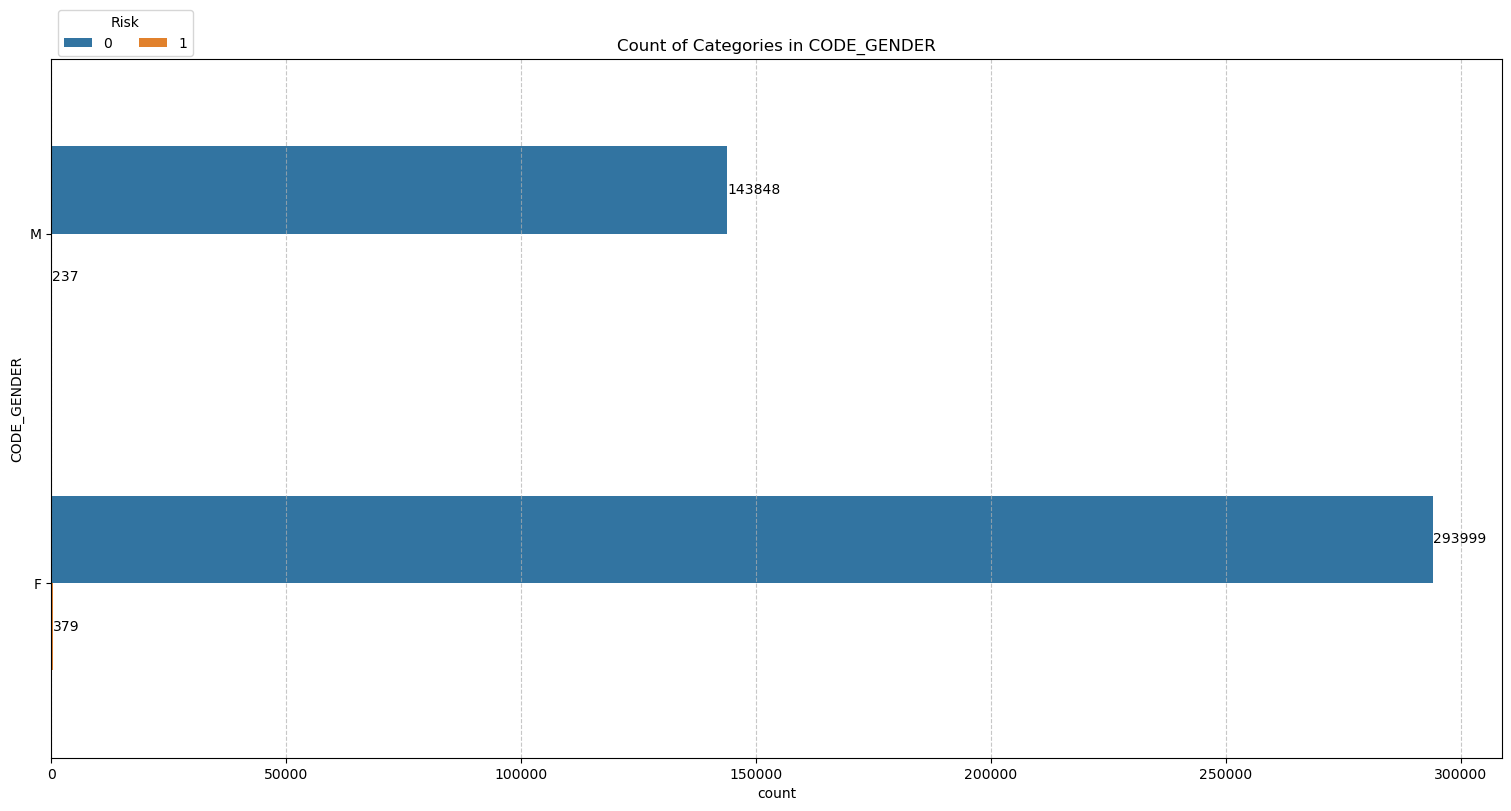


Counts of Categories in NAME_INCOME_TYPE:
 RISK                       0    1
NAME_INCOME_TYPE                 
Commercial associate  100583  143
Pensioner              75348  130
State servant          36146   37
Student                   17    0
Working               225753  306


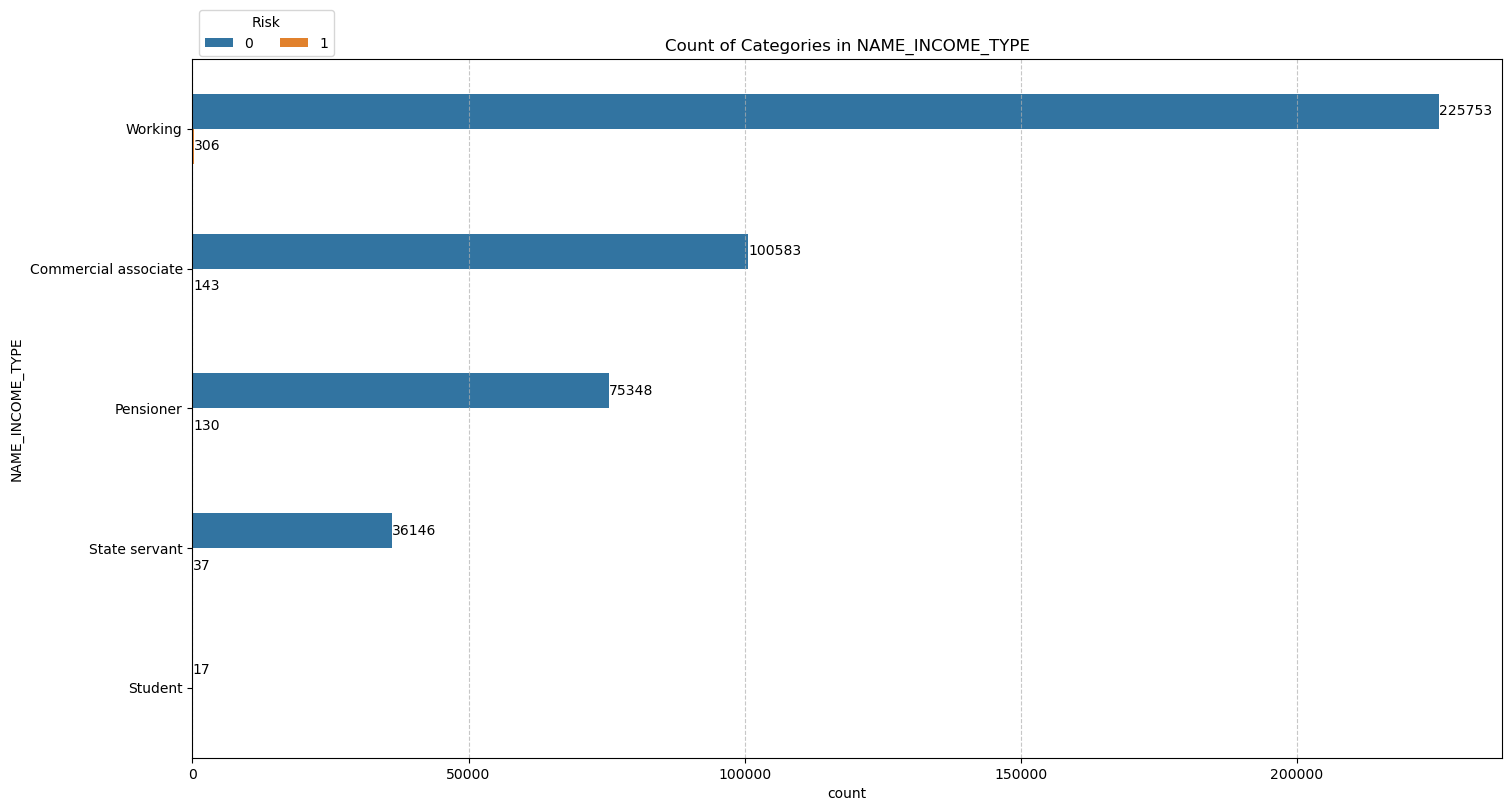


Counts of Categories in NAME_EDUCATION_TYPE:
 RISK                                0    1
NAME_EDUCATION_TYPE                       
Academic degree                   312    0
Higher education               117328  171
Incomplete higher               14812   33
Lower secondary                  4041   10
Secondary / secondary special  301354  402


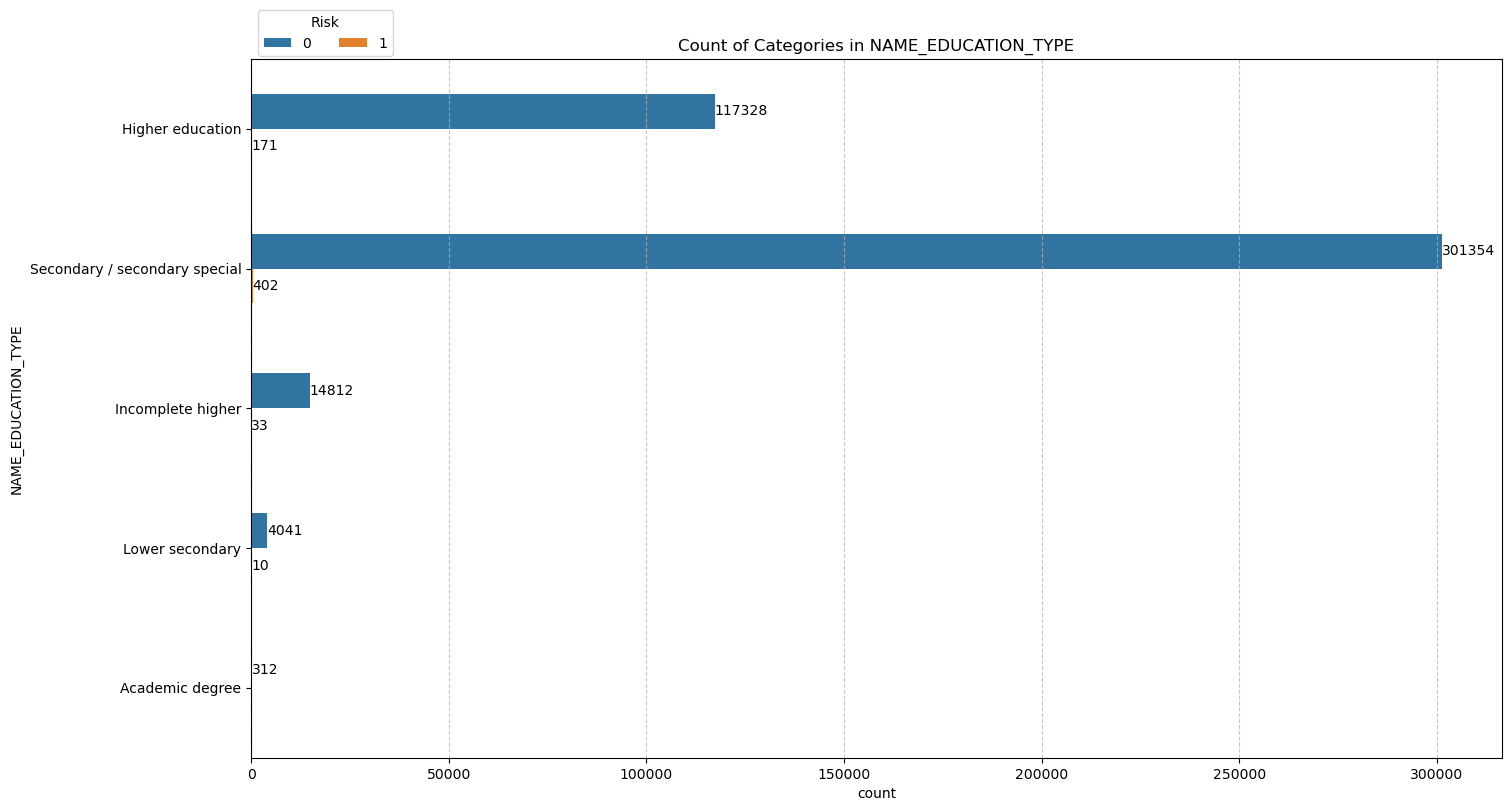


Counts of Categories in NAME_FAMILY_STATUS:
 RISK                       0    1
NAME_FAMILY_STATUS               
Civil marriage         36475   46
Married               299375  393
Separated              27218   31
Single / not married   55154  101
Widow                  19625   45


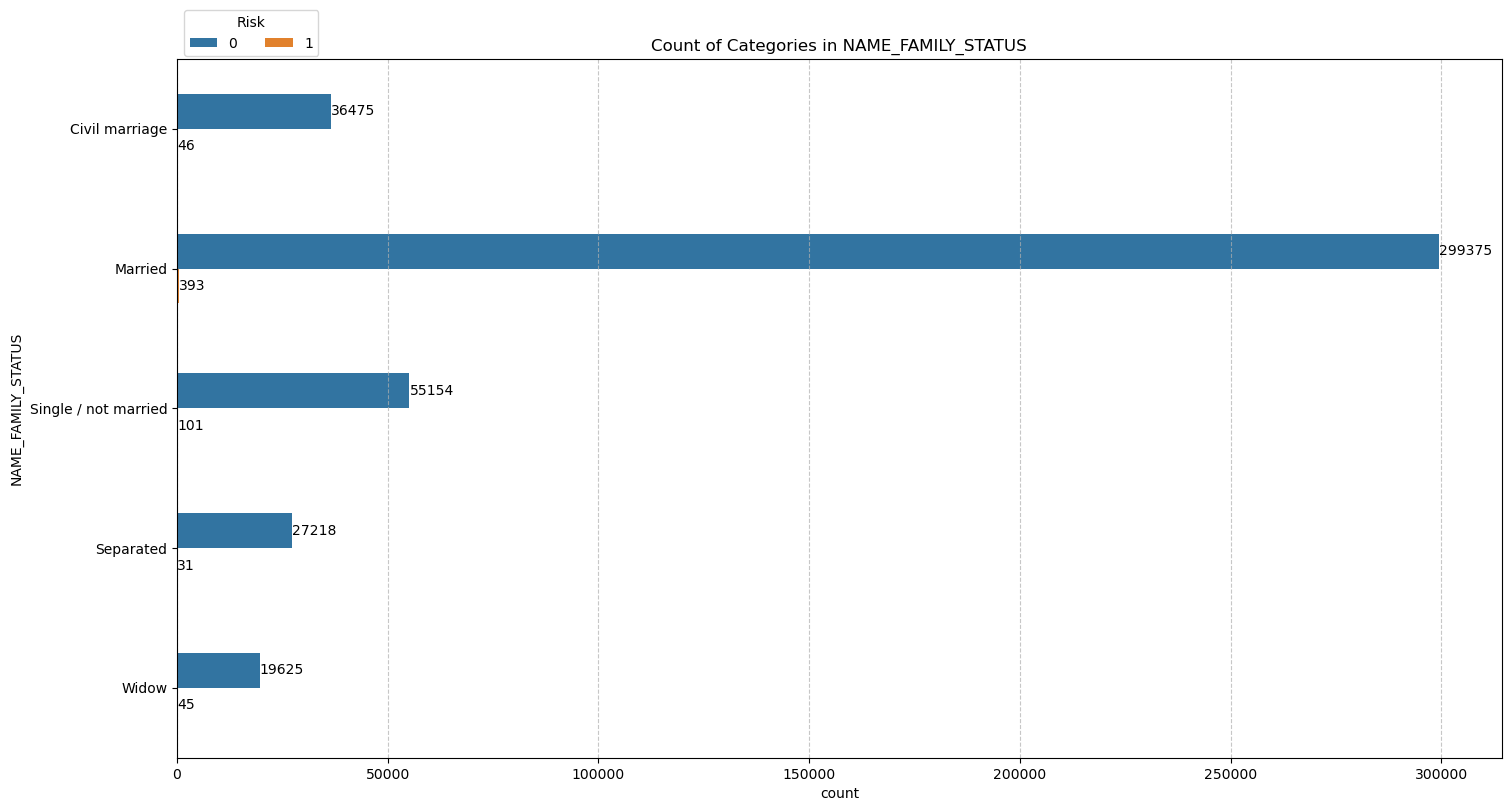


Counts of Categories in NAME_HOUSING_TYPE:
 RISK                      0    1
NAME_HOUSING_TYPE               
Co-op apartment        1536    3
House / apartment    393208  540
Municipal apartment   14181   30
Office apartment       3911    9
Rented apartment       5965    8
With parents          19046   26


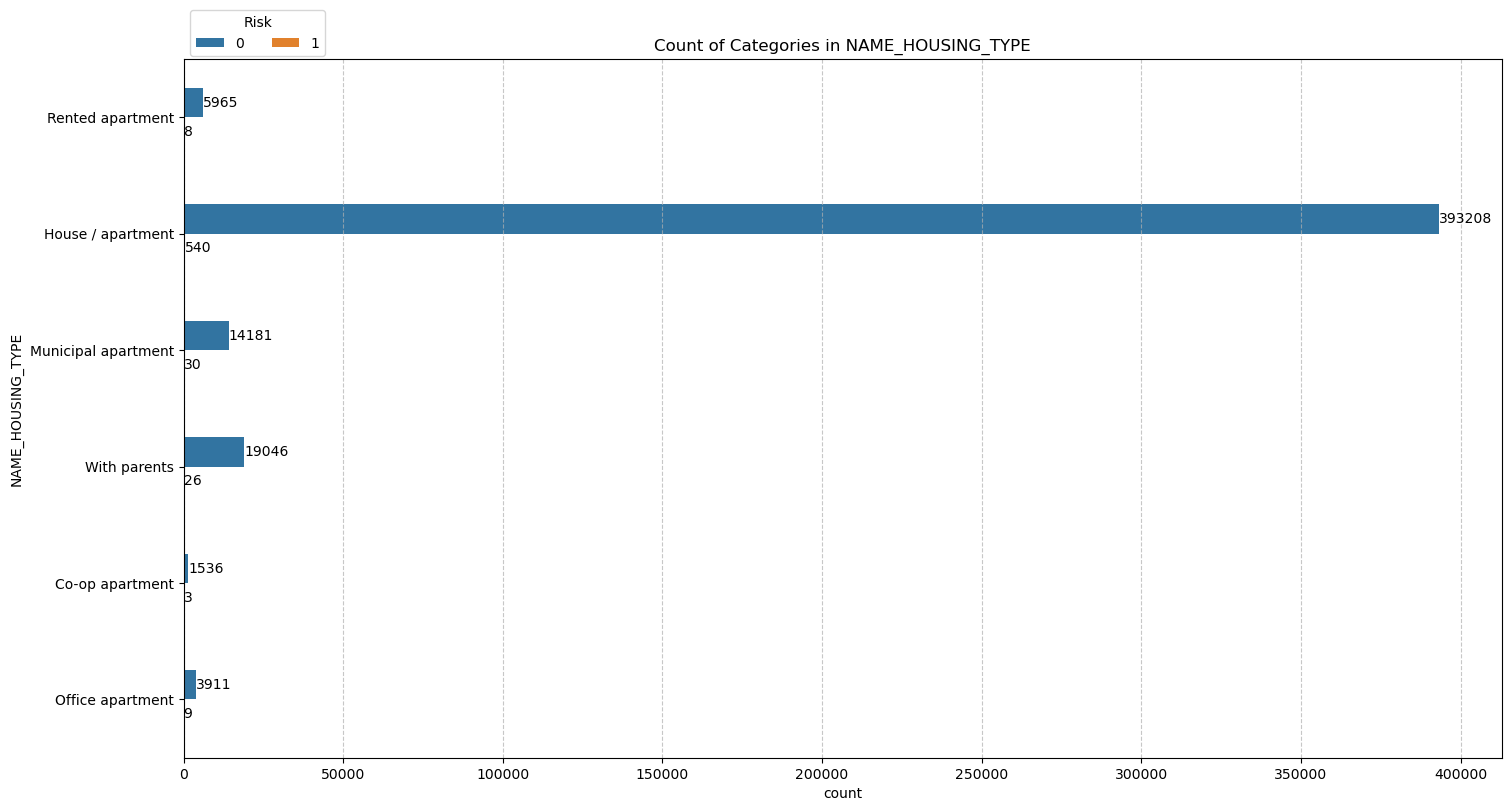


Counts of Categories in OCCUPATION_TYPE:
 RISK                        0    1
OCCUPATION_TYPE                   
Accountants             15957   23
Cleaning staff           5838    5
Cooking staff            8065    9
Core staff              42919   74
Drivers                 26036   49
HR staff                  773    1
High skill tech staff   17253   30
IT staff                  601    3
Laborers                78126   99
Low-skill Laborers       2132    8
Managers                35430   47
Medicine staff          13508   10
Private service staff    3453    2
Realty agents            1041    0
Sales staff             41047   45
Secretaries              2042    2
Security staff           7980   13
Unemployed             133983  194
Waiters/barmen staff     1663    2


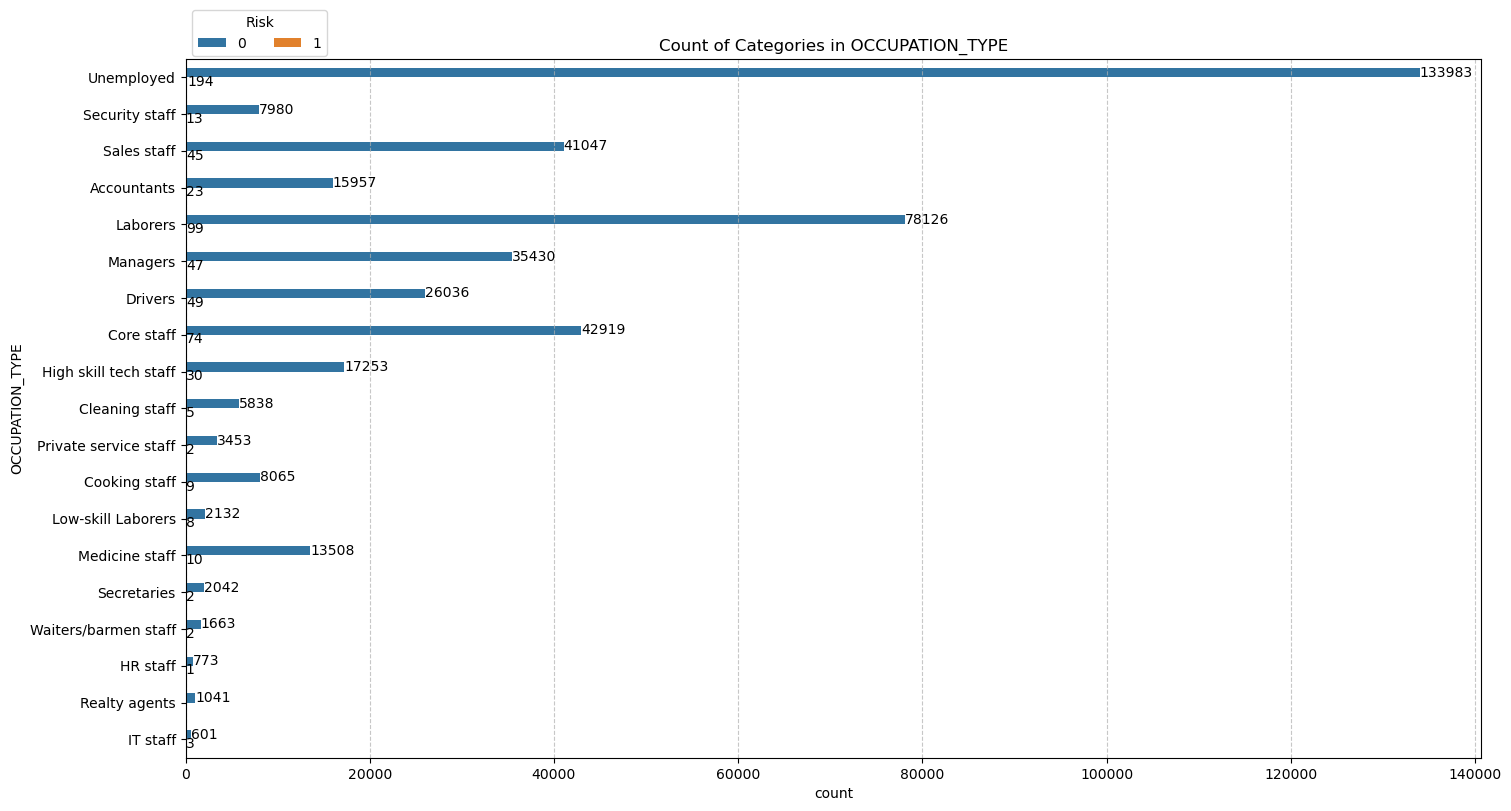

In [26]:
for i, column in enumerate(categorical_cols):
    # Group and count data by category and risk
    category_counts = application_record_df.groupby([column, 'RISK']).size().unstack(fill_value=0)

    # Display the counts DataFrame
    print(f"\nCounts of Categories in {column}:\n", category_counts)

    # Create a plot with a fixed size
    fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)

    # Create a count plot with seaborn
    sns.countplot(data=application_record_df, y=column, hue='RISK', ax=ax, width=0.5)

    # Add bar labels to each bar
    for container in ax.containers:
        ax.bar_label(container)

    # Adjust the legend position above the left corner of the plot
    ax.legend(
        loc='upper left',
        ncol=2,
        bbox_to_anchor=(0, 1.08),  # Fine-tune the position to be just above the plot's left corner
        title='Risk'
    )

    # Add title and gridlines
    ax.set_title(f'Count of Categories in {column}')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

In the above plots we can really see how imbalanced the dataset is, how few bad customers there is and no value that is more prone to bad customers.

#### Numerical
# Her burde vi også gøre det i forhold til om de er i RISK 0 eller 1

In [34]:
risk_df_0 = application_record_df[application_record_df['RISK'] == 0][numerical_cols]
risk_df_1 = application_record_df[application_record_df['RISK'] == 1][numerical_cols]


In [42]:
print("Summary Statistics for RISK = 0:")
display(risk_df_0.describe().round(2))
print("Summary Statistics for RISK = 1:")
display(risk_df_1.describe().round(2))

Summary Statistics for RISK = 0:


,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_FAM_MEMBERS,AGE
count,437847.00,437847.00,437847.00,437847.00,437847.00
mean,0.43,187524.34,60558.00,2.19,43.33
std,0.72,110099.91,138763.66,0.90,11.47
min,0.00,26100.00,-17531.00,1.00,20.00
25%,0.00,121500.00,-3104.00,2.00,34.00
50%,0.00,161100.00,-1468.00,2.00,42.00
75%,1.00,225000.00,-371.00,3.00,53.00
max,19.00,6750000.00,365243.00,20.00,69.00


Summary Statistics for RISK = 1:


,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_FAM_MEMBERS,AGE
count,616.00,616.00,616.00,616.00,616.00
mean,0.43,185864.76,65209.68,2.16,43.13
std,0.74,97509.15,142335.75,0.93,11.69
min,0.00,36000.00,-12827.00,1.00,22.00
25%,0.00,115875.00,-2628.75,2.00,33.00
50%,0.00,162000.00,-1132.00,2.00,42.00
75%,1.00,225000.00,-242.75,3.00,52.25
max,4.00,900000.00,365243.00,6.00,67.00


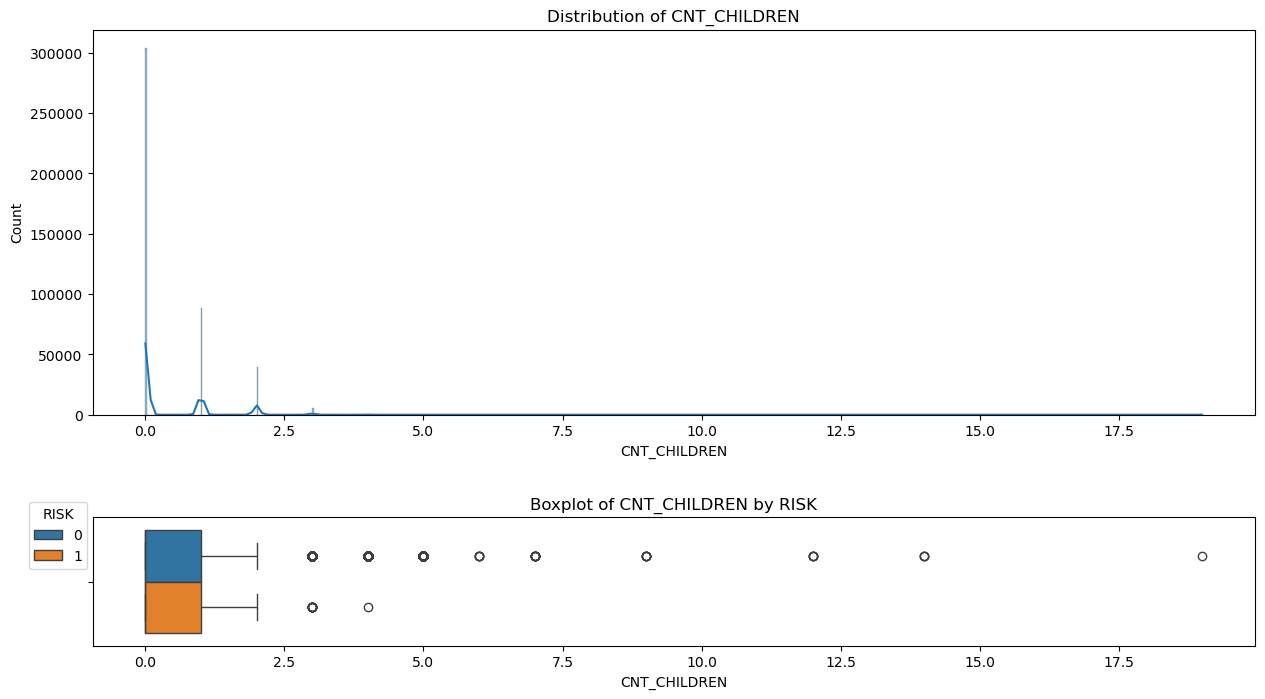

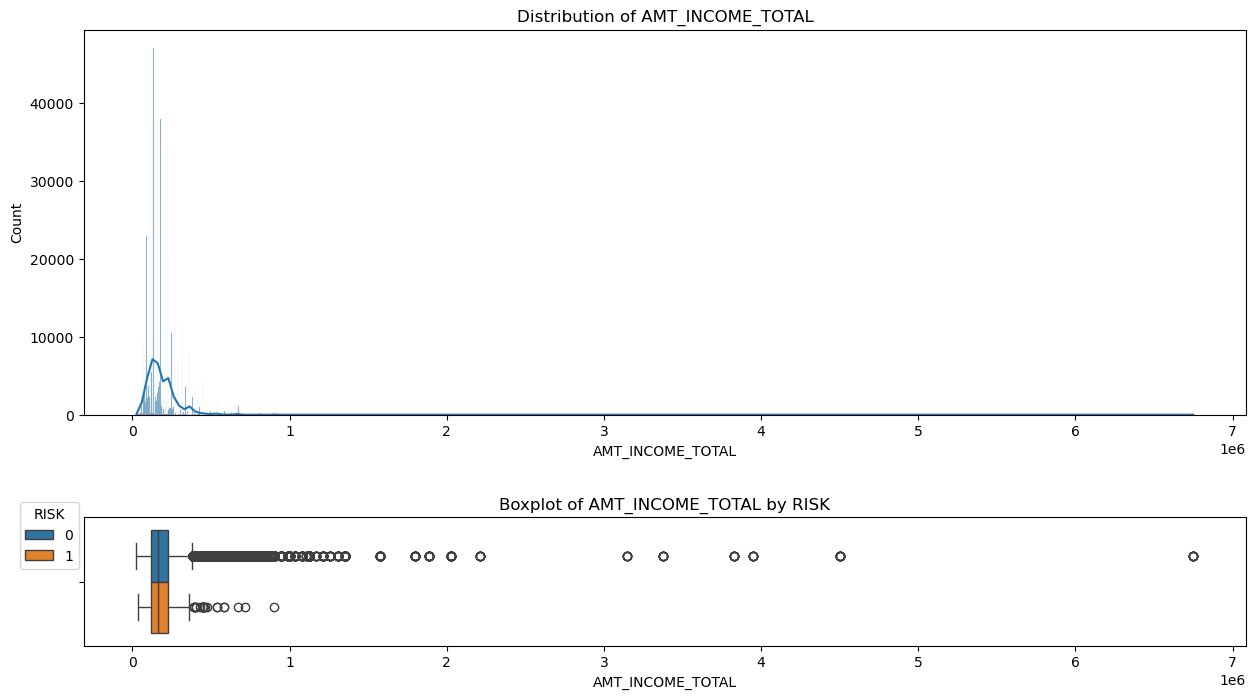

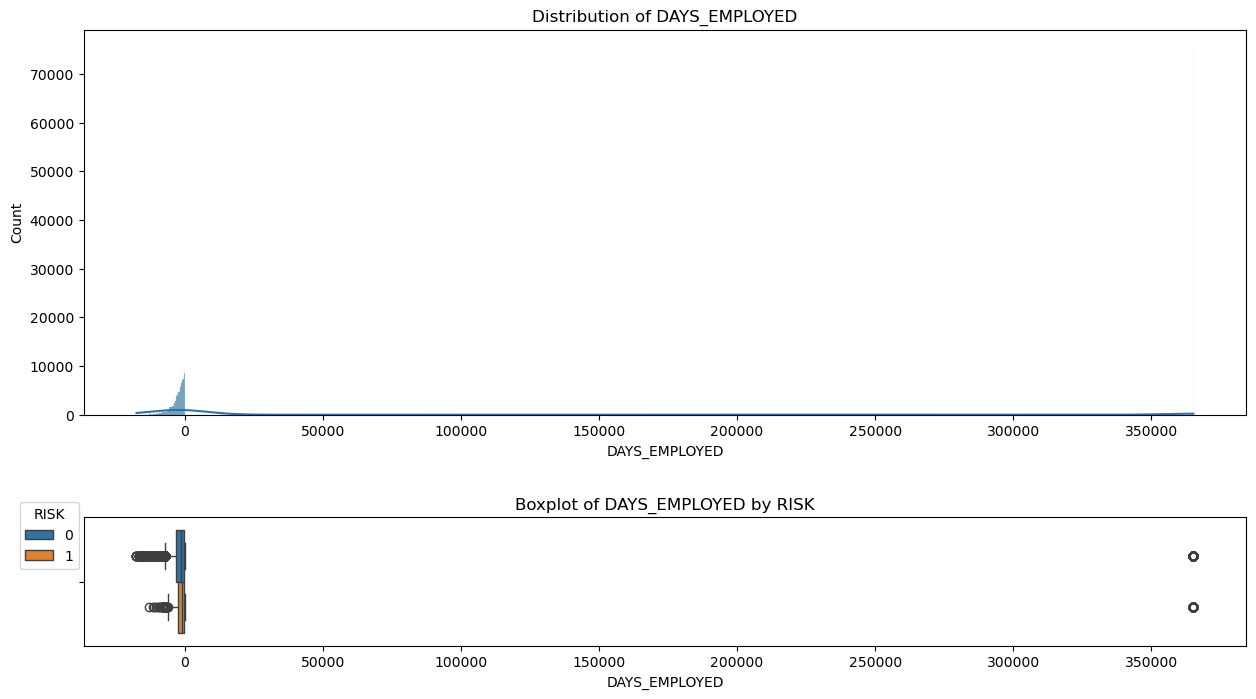

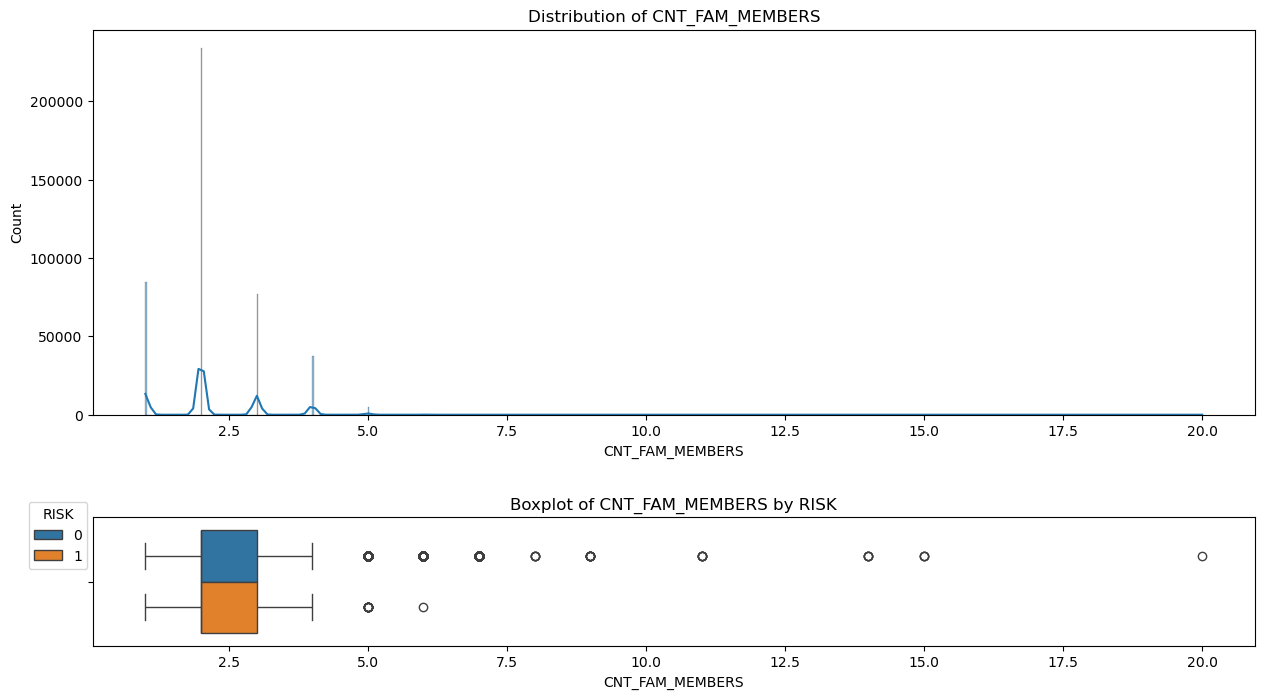

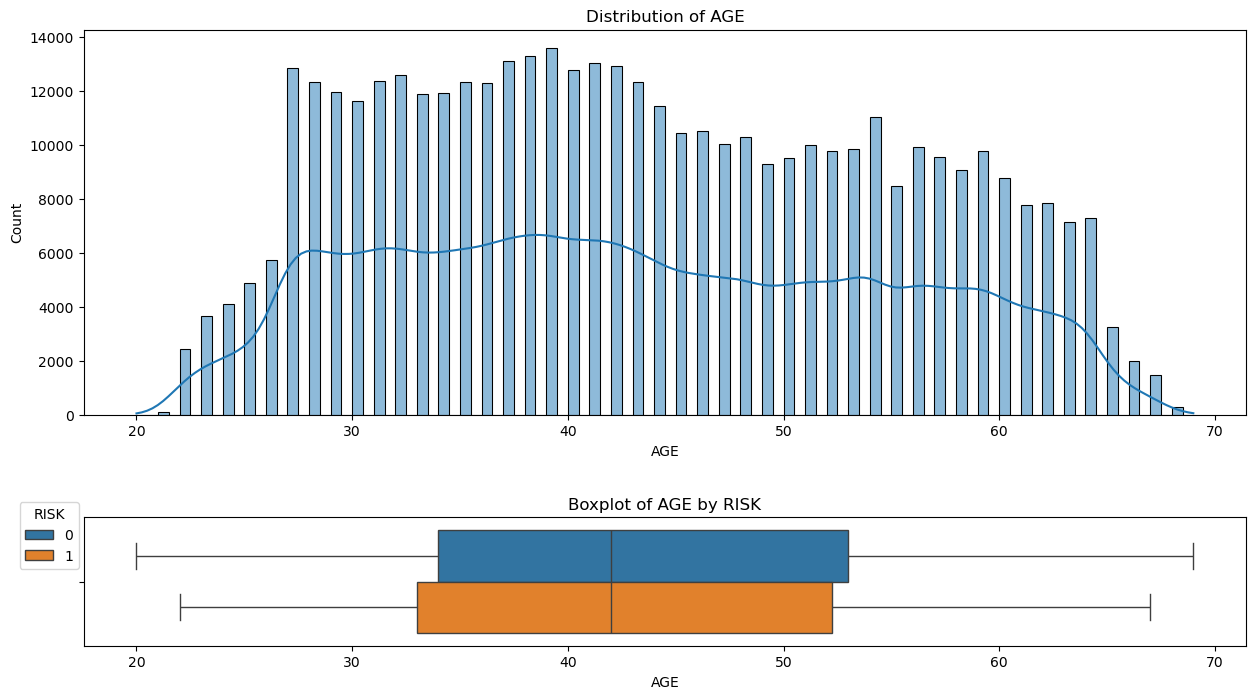

In [60]:
for col in numerical_cols:
    plt.figure(figsize=(15, 8))  # Set the figure size
    grid = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.4)  # Create grid layout
    
    # Subplot for histograms
    plt.subplot(grid[0])
    sns.histplot(application_record_df[col], kde=True)
    plt.title(f'Distribution of {col}')

    # Subplot for boxplots
    plt.subplot(grid[1])
    sns.boxplot(x=col, data=application_record_df, hue='RISK')
    plt.title(f'Boxplot of {col} by RISK')
    plt.legend(title='RISK', loc='lower left', bbox_to_anchor=(-0.055, 0.6), borderaxespad=0)
    
    plt.show()

Comments?

Next we'll construct a correlation matrix to understand the linear relationship between the numeric features.

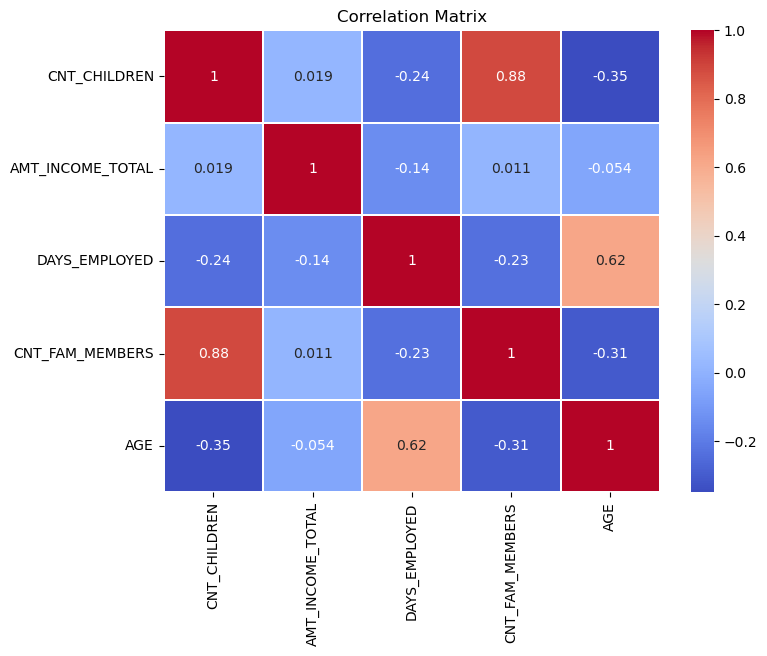

In [29]:
# Compute correlation matrix
correlation_matrix = application_record_df[numerical_cols].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.25)
plt.title('Correlation Matrix')
plt.show()

Comments?

Understanding the relationship between each numerical feature and the response variable could also give us some valuable insights. We'll visualize this with some violin plots.

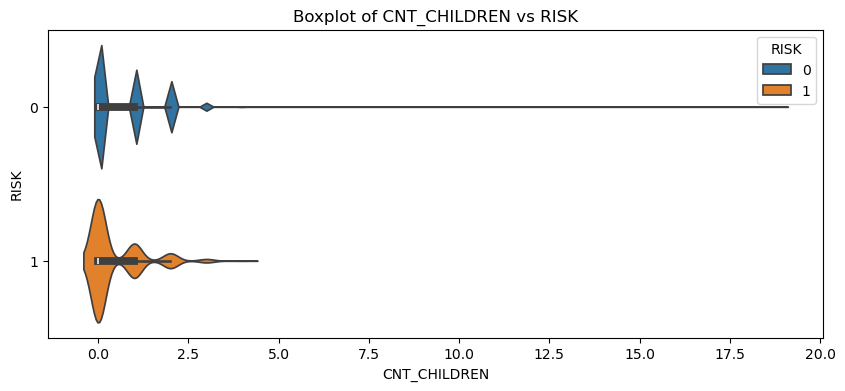

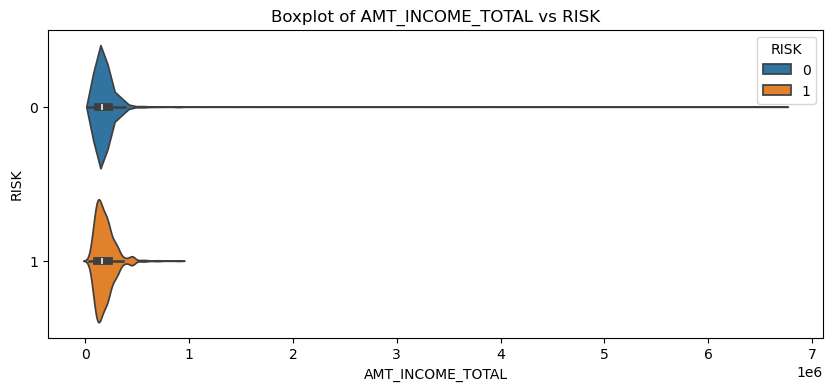

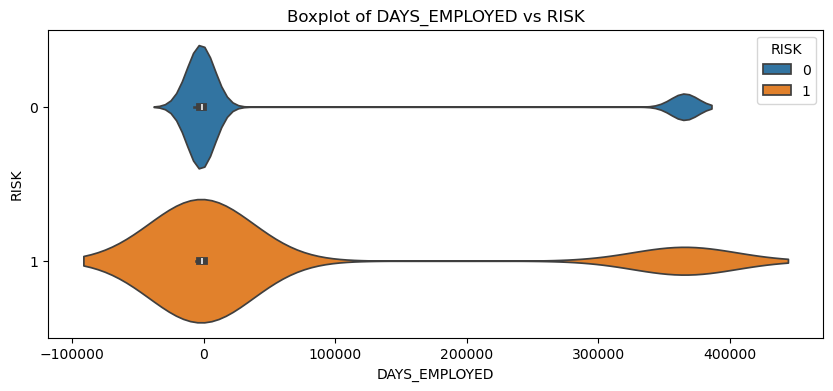

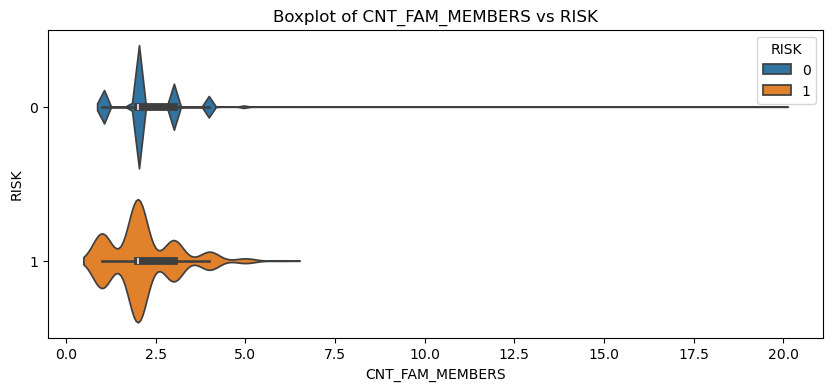

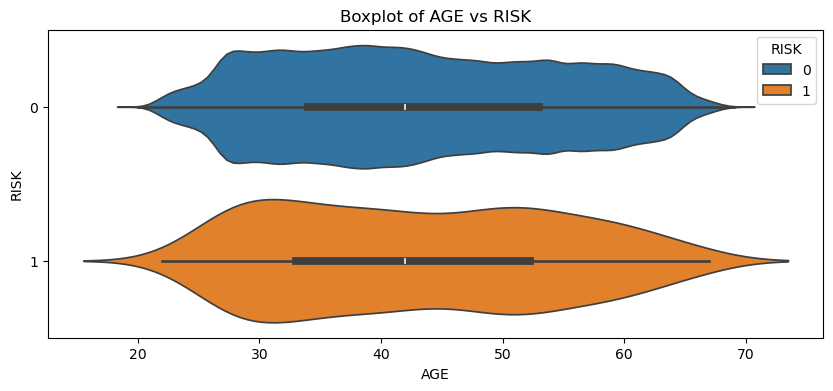

In [61]:
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.violinplot(y='RISK', x=col, data=application_record_df, orient='h', hue='RISK')
    plt.title(f'Boxplot of {col} vs RISK')
    plt.show()

Comments?

#### Binary

In [31]:
binary_cols

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL']

In [32]:
application_record_df[binary_cols]

,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL
ID,,,,,,
5008804,1,1,1,1,0,0
5008805,1,1,1,1,0,0
5008806,1,1,1,0,0,0
5008808,0,1,1,0,1,1
5008809,0,1,1,0,1,1
...,...,...,...,...,...,...
6840104,0,1,1,0,0,0
6840222,0,0,1,0,0,0
6841878,0,0,1,1,0,0


## Feature Engineering & Preprocessing
Now we'll do our last preprocessing to make the data ready to be trained on. This include removing outliers, one-hot encoding, scaling and splitting up our data into training-, validation- and test-set.

In [62]:
# Separate the response variable from the features
target = 'RISK'
Y = application_record_df[target]
x = application_record_df.drop(columns=[target])

In [63]:
# Convert categorical features into numerical format
encoder = OneHotEncoder()
encodedCol = encoder.fit_transform(application_record_df[categorical_cols]).toarray()
encoded_df = pd.DataFrame(encodedCol, columns=encoder.get_feature_names_out(categorical_cols))
x = x.drop(categorical_cols, axis=1)
x.reset_index(inplace=True)
x = pd.concat([x, encoded_df], axis=1)
x.set_index('ID', inplace=True)
x

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unemployed,OCCUPATION_TYPE_Waiters/barmen staff
ID,,,,,,,,,,,,,,,,,,,,,
5008804,1,1,0,427500.0,-4542,1,1,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5008805,1,1,0,427500.0,-4542,1,1,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5008806,1,1,0,112500.0,-1134,1,0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5008808,0,1,0,270000.0,-3051,1,0,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5008809,0,1,0,270000.0,-3051,1,0,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840104,0,1,0,135000.0,365243,1,0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6840222,0,0,0,103500.0,-3007,1,0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6841878,0,0,0,54000.0,-372,1,1,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [64]:
# Split data into traning and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(x, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [74]:
print('X_train shape    : ', X_train.shape)
print('Y_train shape    : ', Y_train.shape)
print('X_val shape      : ', X_val.shape)
print('Y_val shape      : ', Y_val.shape)
print('X_test shape     : ', X_test.shape)
print('Y_test shape     : ', Y_test.shape)

X_train shape    :  (350770, 53)
Y_train shape    :  (350770,)
X_val shape      :  (43846, 53)
Y_val shape      :  (43846,)
X_test shape     :  (43847, 53)
Y_test shape     :  (43847,)


## Model Selection
We will try out different kinds of algorithms to see, which one performs the best:
1. Logistic Regression
1. Random Forest
1. XGBoost
1. Neural Network 

### Logistic Regression

### Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
clf = RandomForestClassifier(max_depth=50, random_state=42)
clf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=50, random_state=42)

In [78]:
clf_pred = clf.predict(X_test)

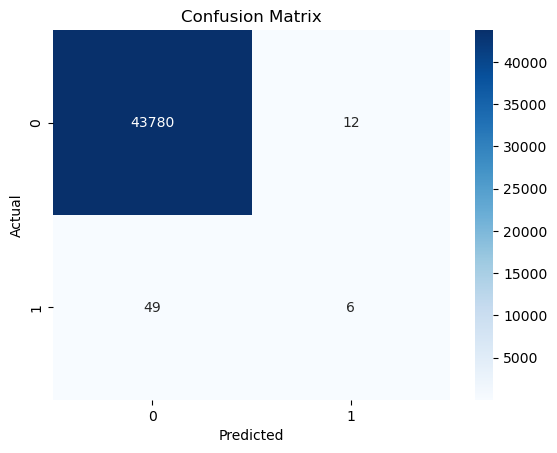

In [79]:
cm = confusion_matrix(Y_test, clf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [81]:
# Compute metrics using the classification report
print(classification_report(Y_test, clf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43792
           1       0.33      0.11      0.16        55

    accuracy                           1.00     43847
   macro avg       0.67      0.55      0.58     43847
weighted avg       1.00      1.00      1.00     43847



### XGBoost

### Neural Network
Husk at tilpasse for imbalance

## Model traning and Evaluation